# Assignment 1
Link: https://github.com/sepehrilami/CNET5442

February 2026

Sepehr Ilami

## Question 0

In [10]:
!conda env list

# conda environments:
#
base                     /Users/sepehr/miniconda
AgentSpeakEnv            /Users/sepehr/miniconda/envs/AgentSpeakEnv
cnet5442              *  /Users/sepehr/miniconda/envs/cnet5442
gametheory               /Users/sepehr/miniconda/envs/gametheory
gt                       /Users/sepehr/miniconda/envs/gt
llmrl                    /Users/sepehr/miniconda/envs/llmrl
mobility                 /Users/sepehr/miniconda/envs/mobility



## Question 1

In [2]:
# --- Imports and setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import zipfile

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 60)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("Ready.")

Ready.


### a)

In [3]:
# load Salaries.csv
dir_path = "../data"

data_path = Path(dir_path) / "Salaries.csv"
salaries = pd.read_csv(data_path)
print(salaries.head())
print(salaries.shape)

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000
(26428, 5)


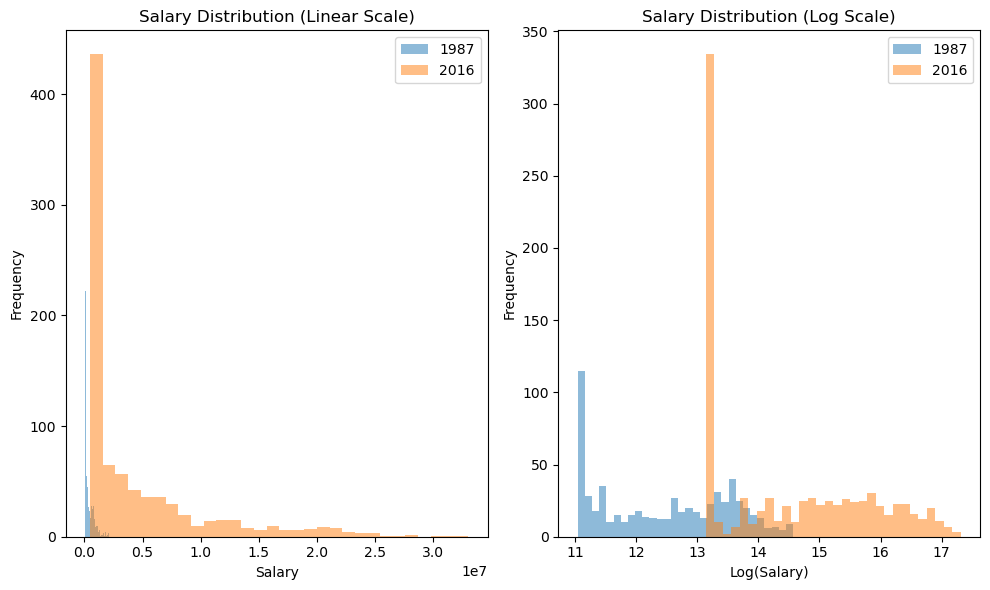

In [4]:
early_year = 1987
late_year = 2016

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=100)

salaries_early = salaries[salaries["yearID"] == early_year]
'''Make one figure with two subplots
of the player salary distribution: 1) one plot on a linear salary scale, and 2) one
plot on a log salary scale (or equivalently, the distribution of log(salary)).'''

# add both years to both plots
salaries_late = salaries[salaries["yearID"] == late_year]

axes[0].hist(salaries_early["salary"], bins=30, alpha=0.5, label=str(early_year))
axes[0].hist(salaries_late["salary"], bins=30, alpha=0.5, label=str(late_year))
axes[0].set_title("Salary Distribution (Linear Scale)")
axes[0].set_xlabel("Salary")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(np.log(salaries_early["salary"]), bins=30, alpha=0.5, label=str(early_year))
axes[1].hist(np.log(salaries_late["salary"]), bins=30, alpha=0.5, label=str(late_year))
axes[1].set_title("Salary Distribution (Log Scale)")
axes[1].set_xlabel("Log(Salary)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

Both plots show how the distribution of salaries has changed over the years. It can be observed that the salaries have generally increased over time, with a noticeable rise in both the minimum and (especially) maximum salary values, and also in the range of salaries.

The log plot is particularly useful for visualizing data that spans several orders of magnitude, as it compresses the scale and allows for better visibility of smaller values. In this case, the log plot helps to highlight the growth in salaries more clearly, especially for lower salary ranges that are less visible in the linear plot.

### b)

In [6]:
'''For each of your two years, report at least four summary statistics (e.g., mean,
median, mode, 90th percentile, 99th percentile, max). Explain why mean and
median can behave differently in a right-skewed distribution'''

years = [early_year, late_year]
summary_stats = {}
for year in years:
    salaries_year = salaries[salaries["yearID"] == year]["salary"]
    summary_stats[year] = {
        "Mean": salaries_year.mean(),
        "Median": salaries_year.median(),
        "Mode": salaries_year.mode().iloc[0] if not salaries_year.mode().empty else np.nan,
        "90th Percentile": salaries_year.quantile(0.9),
        "99th Percentile": salaries_year.quantile(0.99),
        "Max": salaries_year.max()
    }

# make them all scientific notation
for year in summary_stats:
    for stat in summary_stats[year]:
        summary_stats[year][stat] = f"{summary_stats[year][stat]:.2e}"

summary_df = pd.DataFrame(summary_stats).T
display(summary_df)

,Mean,Median,Mode,90th Percentile,99th Percentile,Max
1987,4.35e+05,2.85e+05,6.25e+04,1.00e+06,1.94e+06,2.13e+06
2016,4.40e+06,1.50e+06,5.08e+05,1.26e+07,2.50e+07,3.30e+07


I showed all values in scientific notation, which can clearly tell us how all of those metrics increased by an order of magnitude over the years.
The reason why mean and median are so different in both distributions but more in the late year—as a very right-skewed distribution—is that there are some super high salaries that pull the mean up, while the median remains stable as it is the middle value of the distribution.

### c)

Gini coefficient is a measure of income inequality within a population, mostly used in economics, especially to compare how people across different groups or regions are distributed in terms of income.

It ranges from 0 to 1, where 0 represents perfect equality (everyone has the same income) and 1 represents perfect inequality (one person has all the income, and everyone else has none). Some random fact: Super wealthy countries do not necessarily have low Gini coefficients; for example, USA has a Gini coefficient of around 0.41, indicating a relatively high level of income inequality compared to other developed nations. This shows a few people have SO MUCH more wealth than the rest of the population. And in the other hand, some countries with very low gini coefficients, do not necessarily have high average income; for example, Belarus has a Gini coefficient of around 0.25, indicating a more equal distribution of income among its population, but the average income is relatively low compared to wealthier nations. It means that wealth is more evenly spread out, but the overall wealth is not very high. Everyone are [equally] poor.

The formula is:
G = (1 / (2 * n^2 * μ)) * ΣΣ |xi - xj|
Where:
- G is the Gini coefficient.
- n is the number of individuals in the population.
- μ is the mean income of the population.
- xi and xj are the incomes of individuals i and j, respectively.



In [7]:
def gini_coefficient(salaries):
    """Compute the Gini coefficient of a numpy array."""
    # Ensure the array is sorted. This is very important.
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumulative_salaries = np.cumsum(sorted_salaries)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_salaries))) / (n * cumulative_salaries[-1]) - (n + 1) / n
    return gini

gini_early = gini_coefficient(salaries_early["salary"].values)
gini_late = gini_coefficient(salaries_late["salary"].values)

print(f"Gini Coefficient in {early_year}: {gini_early:.4f}")
print(f"Gini Coefficient in {late_year}: {gini_late:.4f}")

Gini Coefficient in 1987: 0.5104
Gini Coefficient in 2016: 0.6247


### d)

      Gini Coefficient
Year                  
1985          0.384328
1986          0.488756
1987          0.510426
1988          0.507338
1989          0.532834


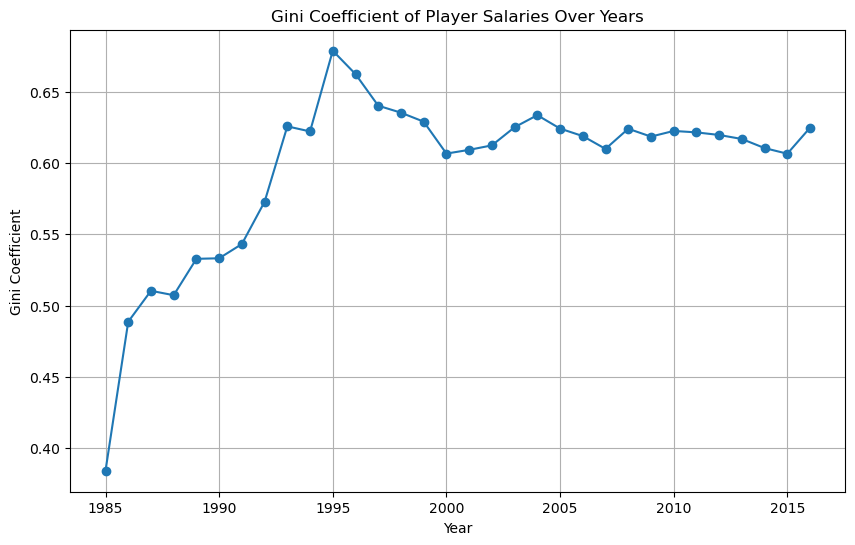

In [9]:
# compute gini coefficients for every year in the dataset
gini_by_year = {}
for year in salaries["yearID"].unique():
    salaries_year = salaries[salaries["yearID"] == year]["salary"].values
    gini_by_year[year] = gini_coefficient(salaries_year)
gini_df = pd.DataFrame.from_dict(gini_by_year, orient='index', columns=['Gini Coefficient'])
gini_df.index.name = 'Year'
print(gini_df.head())

# plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(gini_df.index, gini_df['Gini Coefficient'], marker='o')
ax.set_title("Gini Coefficient of Player Salaries Over Years")
ax.set_xlabel("Year")
ax.set_ylabel("Gini Coefficient")
plt.grid()
plt.show()

As expected, the Gini coefficient has increased from ~0.40 in 1985 to over 0.65 in 1995, and remained stable after that, indicating a rise in income inequality over the decade. This suggests that the distribution of salaries has become more unequal, due to the fact that there was uneven revenue growth in the teams. This could be related to the tech industry and analytical methods that boomed in the 90s, which led to some teams and players earning significantly more than others, thus increasing the overall income inequality within the league.

## Question 2

### a)

Define the following terms:
1) Standard error: The standard error of an estimate is the standard deviation of the sampling distribution of that estimate. It measures the precision of an estimate. If it is small, it indicates that the estimate is likely to be close to the true population parameter. Note: The reason we have such thing at all is because sampling populations can never be equal to the actual population, so we need a way to measure how far off we are likely to be.
2) Heteroskedasticity: The condition where the variance of the error terms in a regression model is not constant across observations. Imagine plotting the residuals of a regression model against the predicted values. If the spread of the residuals increases or decreases as the predicted values change, this indicates heteroskedasticity. This violates one of the key assumptions of ordinary least squares (OLS) regression, which assumes that the variance of the error terms is constant (homoskedasticity). Heteroskedasticity can lead to inefficient estimates and invalid statistical inferences if not addressed properly.
3) Multicollinearity: The presence of high correlation among independent variables in a regression model, which can make it difficult to assess the individual effect of each variable. When independent variables are highly correlated, it can lead to unstable estimates of regression coefficients, making it challenging to determine the true relationship between each independent variable and the dependent variable. This can result in inflated standard errors and reduced statistical power.
4) Fixed effects: A method for controlling unobserved heterogeneity in panel data by including dummy variables for each entity (e.g., each player or team or year).

### b)

### c)

### d)

## Question 3

### a)

### b)

### c)